# Assignment 6 - Computational Physics
#### The goal of this assignment is to find gravitational waves from the help of two detectors (Hanford and Livingston). The gravitational wave events need to be seen by both detectors to be considered real. 

## Part 1
We are asked to come up with a noise model for the Livingston and Hanford detectors seperately. 

The following cell is used to read the hdf5 files. 

In [247]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import glob
import json

#Reading the hdf5 files is pulled from Jon's simple_ligo_class.py

#Reading template. 
def read_template(filename):
    datafile=h5py.File(filename,'r')
    template=datafile['template']
    th=template[0]
    tl=template[1]
    return th,tl #returns template for Hanford detector

#Reading the file. 
def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

#Defining the 4 event names.
eventname = []
eventname = ['GW150914','GW151226','LVT151012','GW170104']

fnjson = "BBH_events_v3.json"
events = json.load(open(fnjson,"r"))

fn_H1=[]
fn_L1=[]
fn_template=[]
fs=[]
tevent=[]
fband=[]

#Extract the parameters for the desired event:
for i in range(len(eventname)):
    event = events[eventname[i]]
    fn_H1.append(event['fn_H1'])              # File name for H1 data
    fn_L1.append(event['fn_L1'])              # File name for L1 data
    fn_template.append(event['fn_template'])  # File name for template waveform
    fs.append(event['fs'])                    # Set sampling rate
    tevent.append(event['tevent'])            # Set approximate event GPS time
    fband.append(event['fband'])              # frequency band for bandpassing signal
    print("Reading in parameters for event " + event["name"])


Reading in parameters for event GW150914
Reading in parameters for event GW151226
Reading in parameters for event LVT151012
Reading in parameters for event GW170104


In [234]:
#Here I just want to see how events look like in general. 
print(events)
#Seems like every event has the same fs value. 

{'GW150914': {'name': 'GW150914', 'fn_H1': 'H-H1_LOSC_4_V2-1126259446-32.hdf5', 'fn_L1': 'L-L1_LOSC_4_V2-1126259446-32.hdf5', 'fn_template': 'GW150914_4_template.hdf5', 'fs': 4096, 'tevent': 1126259462.44, 'utcevent': '2015-09-14T09:50:45.44', 'm1': 41.743, 'm2': 29.237, 'a1': 0.355, 'a2': -0.769, 'approx': 'lalsim.SEOBNRv2', 'fband': [43.0, 300.0], 'f_min': 10.0}, 'LVT151012': {'name': 'LVT151012', 'fn_H1': 'H-H1_LOSC_4_V2-1128678884-32.hdf5', 'fn_L1': 'L-L1_LOSC_4_V2-1128678884-32.hdf5', 'fn_template': 'LVT151012_4_template.hdf5', 'fs': 4096, 'tevent': 1128678900.44, 'utcevent': '2015-10-12T09:54:43.44', 'm1': 44.111, 'm2': 11.205, 'a1': 0.447, 'a2': -0.434, 'approx': 'lalsim.SEOBNRv2', 'fband': [43.0, 400.0], 'f_min': 10.0}, 'GW151226': {'name': 'GW151226', 'fn_H1': 'H-H1_LOSC_4_V2-1135136334-32.hdf5', 'fn_L1': 'L-L1_LOSC_4_V2-1135136334-32.hdf5', 'fn_template': 'GW151226_4_template.hdf5', 'fs': 4096, 'tevent': 1135136350.65, 'utcevent': '2015-12-26T03:38:53.65', 'm1': 19.6427, 'm2'

Now that I've read in the files, I can write the noise models for both Hanford and Livingston. 

### Hanford

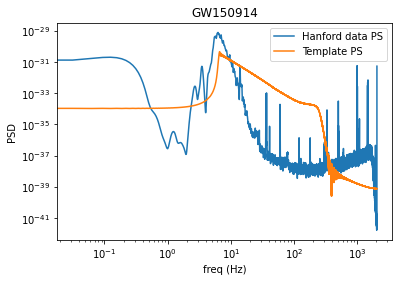

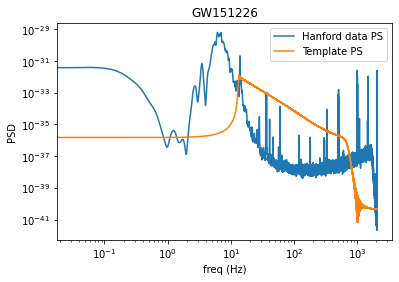

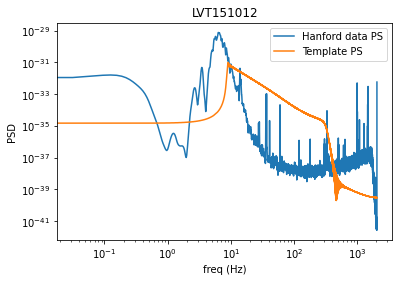

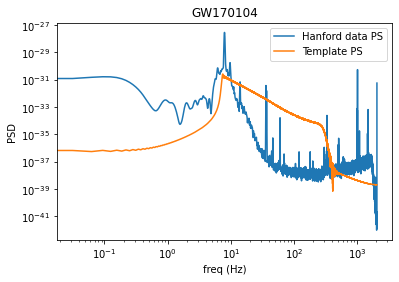

In [267]:
#Function was taken from read_ligo_class.py
def make_flat_window(n,m): #can get flatter noise with this
    tmp=np.blackman(m)
    win=np.ones(n)
    mm=m//2
    win[:mm]=tmp[:mm]
    win[-mm:]=tmp[-mm:]
    return win

strain_H=[]
dt_H=[]
utc_H=[]
t_H=[]
t_L=[]

#Extracting info needed to do noise model & power spectrum
#for all 4 events concerning.
for i in range(len(fn_H1)):
    fname=fn_H1[i]
    strain,dt,utc=read_file(fname)
    template_name=fn_template[i]
    th,tl=read_template(template_name)
    
    strain_H.append(strain)
    dt_H.append(dt)
    utc_H.append(utc)
    t_H.append(th)
    t_L.append(tl)
    
    
n=len(strain)
win=make_flat_window(n,n//5)

sft_H=[]
Nft_H=[]

#Want x-axis in frequency
freq=(np.fft.rfftfreq(len(strain_H[0]),dt_H[0]))

for i in range(len(fn_H1)):
    sft_H.append(np.fft.rfft(win*strain_H[i])) #doing the FT
    Nft_H.append(np.abs(sft_H[i])**2) #this is the noise? I think this is the PS.
    
    #because only doing this once doesn't yield exactly what we're looking for
    #we can do this averaging out a few times. 
    j=0
    for j in range(10):
        Nft_H[i]=(Nft_H[i]+np.roll(Nft_H[i],1)+np.roll(Nft_H[i],-1))/3 #average of nearest neighbours
    
    title=eventname[i]
    plt.loglog(freq,np.abs(Nft_H[i]),label='Hanford data PS')
    plt.loglog(freq,np.abs(np.fft.rfft(t_H[i]))**2,label='Template PS')
    plt.title(title)
    plt.legend()
    plt.ylabel('PSD')
    plt.xlabel('freq (Hz)')
    plt.show()


### Livingston

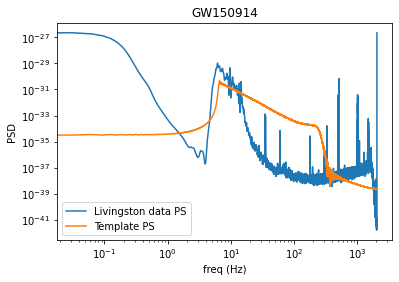

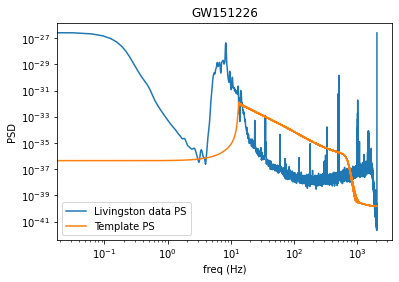

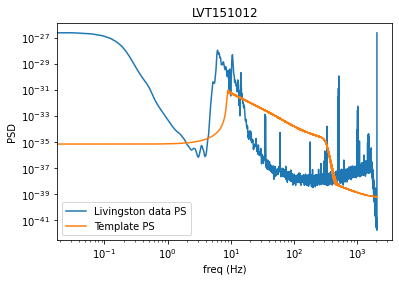

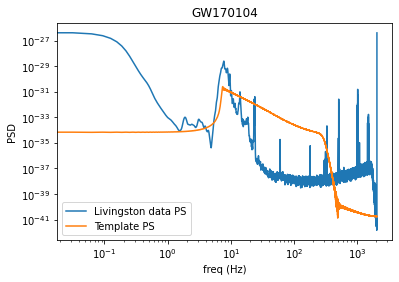

In [268]:
# Window function already defined in previous cell. 

strain_L=[]
dt_L=[]
utc_L=[]

#Extracting info needed to do noise model & power spectrum
#for all 4 events concerning.
for i in range(len(fn_L1)):
    fname=fn_L1[i]
    strain,dt,utc=read_file(fname)
    template_name=fn_template[i]
    th,tl=read_template(template_name)
    
    strain_L.append(strain)
    dt_L.append(dt)
    utc_L.append(utc)
    
    
n=len(strain)
win=make_flat_window(n,n//5)

sft_L=[]
Nft_L=[]

for i in range(len(fn_L1)):
    sft_L.append(np.fft.rfft(win*strain_L[i])) #doing the FT
    Nft_L.append(np.abs(sft_L[i])**2) #this is the noise? I think this is the PS.
    
    #because only doing this once doesn't yield exactly what we're looking for
    #we can do this averaging out a few times. 
    j=0
    for j in range(10):
        Nft_L[i]=(Nft_L[i]+np.roll(Nft_L[i],1)+np.roll(Nft_L[i],-1))/3 #average of nearest neighbours
    
    title=eventname[i]
    plt.loglog(freq,np.abs(Nft_L[i]),label='Livingston data PS')
    plt.loglog(freq,np.abs(np.fft.rfft(t_L[i]))**2,label='Template PS')
    plt.title(title)
    plt.legend()
    plt.ylabel('PSD')
    plt.xlabel('freq (Hz)')
    plt.show()


#### Notes on Part 1:
The window I used was the blackman window, which was used in the Ligo notebook as well. 
Blackman window is designed to have minal leakage. By flattening the window, the noise is more consistent (flatter). This also avoids tapering the data/template. 
Blackman window is also used in smoothing the data. 

## Part 2:

The goal of this part is to use a matched filter to search for the 4 sets of events. 
Need to prewhiten THEN do the match filter. 

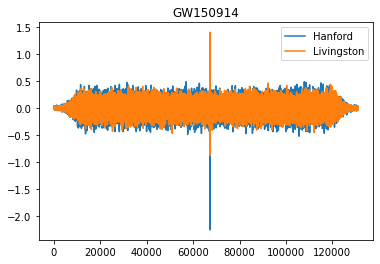

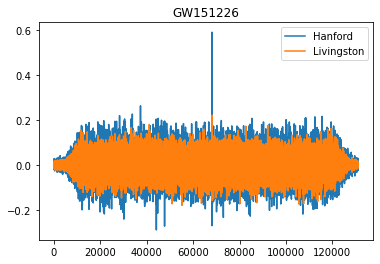

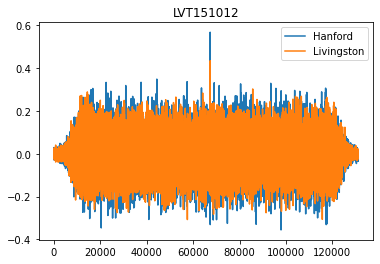

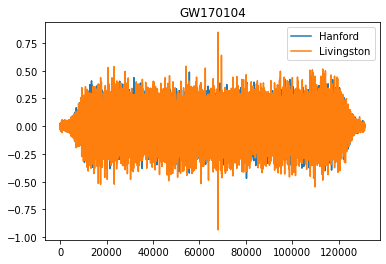

In [271]:
sft_white_H=[]
sft_white_L=[]

tft_white_H=[]
tft_white_L=[]

xcorr_H=[]
xcorr_L=[]

t_white=np.fft.irfft(tft_white)
i=0
for i in range(len(eventname)):
    #prewhitening noise and template for both Hanford and Livingston
    sft_white_H.append(sft_H[i]/np.sqrt(Nft_H[i])) 
    sft_white_L.append(sft_L[i]/np.sqrt(Nft_L[i]))
    tft_white_H.append(np.fft.rfft(t_H[i]*win)/np.sqrt(Nft_H[i]))
    tft_white_L.append(np.fft.rfft(t_L[i]*win)/np.sqrt(Nft_L[i]))
    
    #doing the match filter
    xcorr_H.append(np.fft.irfft(sft_white_H[i]*np.conj(tft_white_H[i])))
    xcorr_L.append(np.fft.irfft(sft_white_L[i]*np.conj(tft_white_L[i])))
    
    plt.plot(np.fft.fftshift(xcorr_H[i]),label='Hanford')
    plt.plot(np.fft.fftshift(xcorr_L[i]),label='Livingston')
    plt.title(eventname[i])
    plt.legend()
    plt.show()
    

### Part 3:
The goal of this part is to estimate the noise for each event and give the signal to noise ratio (SNR). This needs to be done for the individual detectors, and for the combined Livingston + Hanford events. 
Inspired by Jon's read_ligo_class.py

In [310]:
mysnr_H=[]
mysnr_L=[]
combined=[]

for i in range(len(eventname)):
    #getting std of my noise
    mynoise_H=np.std(xcorr_H[i])
    mynoise_L=np.std(xcorr_L[i])
    
    #getting SNRs
    mysnr_H.append(np.max(np.abs(xcorr_H[i]))/mynoise_H)
    mysnr_L.append(np.max(np.abs(xcorr_L[i]))/mynoise_L)
    combined.append(np.sqrt(np.max(np.abs(mysnr_H[i]))**2+np.max(np.abs(mysnr_L[i]))**2))
    
    print(eventname[i])
    print('Hanford SNR:',mysnr_H[i])
    print('Livingston SNR:',mysnr_L[i])
    print('Combined SNR:',combined[i])
    print('Chance that it is not a gravitational wave signal',np.exp(-combined[i]**2/2))
    print('')


GW150914
Hanford SNR: 18.125473857655326
Livingston SNR: 13.040270883479602
Combined SNR: 22.32893788963265
Chance that it is not a gravitational wave signal 5.425128017341416e-109

GW151226
Hanford SNR: 10.36638416760537
Livingston SNR: 5.53617605458255
Combined SNR: 11.752070711909136
Chance that it is not a gravitational wave signal 1.0222128937166109e-30

LVT151012
Hanford SNR: 6.857681070777813
Livingston SNR: 5.840098111462667
Combined SNR: 9.007471100148706
Chance that it is not a gravitational wave signal 2.4091256091441456e-18

GW170104
Hanford SNR: 7.90568839314308
Livingston SNR: 7.17794298278113
Combined SNR: 10.67814470933664
Chance that it is not a gravitational wave signal 1.7388780529220368e-25



### Part 4:
The goal of this part is to find the analytic SNR for each event that we would expect from our noise model. This is simply done by: SNR=(mode * (templateFT) ** 2 / noise PS)^0.5
This is indicated in the Ligo class slide. 

In [316]:
ana_SNR_H=[]
ana_SNR_L=[]
ana_combined=[]

for i in range(len(eventname)):
    ana_SNR_H.append(np.fft.irfft(np.sqrt((np.fft.rfft(t_H[i]*win)**2/Nft_H[i]))))
    ana_SNR_L.append(np.fft.irfft(np.sqrt((np.fft.rfft(t_L[i]*win))**2/Nft_L[i])))
    ana_combined.append(np.sqrt(np.max(np.abs(ana_SNR_H[i]))**2+np.max(np.abs(ana_SNR_L[i]))**2))
    print(eventname[i])
    print('Analytical SNR for Hanford',np.max(np.abs(ana_SNR_H[i])))
    print('Analytical SNR for Livingston',np.max(np.abs(ana_SNR_L[i])))
    print('Analytical combined SNR',ana_combined[i])
    print('')

print('--------------------------------------')
#calculating the error between analytical and experimental    
for i in range(len(eventname)):
    print(eventname[i])
    print('Error in Hanford',np.mean(np.abs(ana_SNR_H[i]-mysnr_H[i])))
    print('Error in Livingston',np.mean(np.abs(ana_SNR_L[i]-mysnr_L[i])))
    print('Error in combined:',np.mean(np.abs(ana_combined[i]-combined[i])))
    print('')
    

GW150914
Analytical SNR for Hanford 10.010116923764983
Analytical SNR for Livingston 8.879126408514134
Analytical combined SNR 13.380632518899068

GW151226
Analytical SNR for Hanford 5.462967036692983
Analytical SNR for Livingston 4.5411471475421425
Analytical combined SNR 7.103944415578169

LVT151012
Analytical SNR for Hanford 6.6675024533034275
Analytical SNR for Livingston 7.313139894150126
Analytical combined SNR 9.896342964763162

GW170104
Analytical SNR for Hanford 8.447034811936202
Analytical SNR for Livingston 10.468534452401498
Analytical combined SNR 13.451491021265234

--------------------------------------
GW150914
Error in Hanford 18.12547385641805
Error in Livingston 13.040270883458575
Error in combined: 8.94830537073358

GW151226
Error in Hanford 10.366384167507562
Error in Livingston 5.536176054582427
Error in combined: 4.648126296330967

LVT151012
Error in Hanford 6.85768107024996
Error in Livingston 5.840171274517967
Error in combined: 0.8888718646144564

GW170104
Err

I had originally thought that the following was the analytical SNR:
ana_SNR_L.append(np.max(np.abs((np.fft.irfft(tft_white_L[i] * np.conj(tft_white_L[i]))/mynoise_L))))

But this yields really big values, in the 10^3, 10^4 range. 

So i decided to use my non-whitened/raw template data. These yielded more reasonable numbers as shown. However, I expected these values to be larger than my experimental SNR values. This is because of the likelihood of the signal to be just noise, exp(-SNR^2/2), as defined in our class. The larger the SNR value, the smaller this chance is. 

The difference between the analytical SNRs and my SNR values is perhaps due to the mode term in the equation explained above. I didn't include this into my calculation. That being said, the values are quite similar despite their relatively large error as calculated above. 

### Part 5:
The goal of this part is to find the frequency from each event where half the weight comes from above that frequency and half below. According to tutorial, this can be found by doing the cummulative integral of MF in complex space. We can find the frequency that's equal to 1/2 its maximum value. 
Not really working with MF... Seems like it's not the proper length. Perhaps doing with the PSD of tft_white will yield better results.

In [355]:
cum_MF_H=[]
cum_MF_L=[]
half_max_H=[]
half_max_L=[]

for i in range(len(eventname)):
    #cumsum of match filter
    cum_MF_H.append(np.abs(tft_white_H[i]**2))
    cum_MF_L.append(np.abs(tft_white_L[i]**2))
    
    #Getting half of the maximum
    half_max_H.append(np.max(cum_MF_H)*0.5)
    half_max_L.append(np.max(cum_MF_L)*0.5)
    
    #Now I want to subtract the cumsum by half the max. 
    han=np.abs(cum_MF_H[i]-np.ones(len(cum_MF_H[i]))*half_max_H[i])
    liv=np.abs(cum_MF_L[i]-np.ones(len(cum_MF_L[i]))*half_max_L[i])
    
    #This will give the index at which the weight is 1/2 above and 1/2 below
    indexH=np.argmin(han)
    indexL=np.argmin(liv)
    freq_H=freq[indexH]
    freq_L=freq[indexL]
    
    print(eventname[i])
    print(freq_H)
    print(freq_L)
    print('')


GW150914
59.3125
36.125

GW151226
54.5
74.1875

LVT151012
45.6875
50.4375

GW170104
46.9375
45.09375



### Part 6:
The goal of this part is to localize the time of arrival the of the DW? Should compare arrival times at different detectors. Typical positional uncertainty given than the detectors are a few thousabnd km apart?

According to LIGO's website, the detectors are approximately 3002km apart. Thus, they will not feel the GW at the same time. According to https://spaceplace.nasa.gov/gravitational-waves/en/, GW travel at the speed of light, i.e. 3x10^8 m/s. This means that the theoretical time for light to travel between the two detectors is approx 0.01s. Thus this could be the typical uncertainty. 

In [356]:
#getting time
t=np.fft.fftfreq(n,fs[0])*n
#print(np.min(t))
t=t-np.min(t) #starting time at 0s. 

for i in range(len(eventname)):
    event_time_H = np.argmax(abs(xcorr_H[i]))
    event_time_L = np.argmax(abs(xcorr_L[i]))
    
    print(eventname[i])
    print('Time for Hanford',t[event_time_H])
    print('Time for Livingston',t[event_time_L])
    print('Difference=',np.abs(t[event_time_H]-t[event_time_L]))
    print('')
    

GW150914
Time for Hanford 16.4404296875
Time for Livingston 16.431640625
Difference= 0.0087890625

GW151226
Time for Hanford 16.647705078125
Time for Livingston 16.64794921875
Difference= 0.000244140625

LVT151012
Time for Hanford 16.44140625
Time for Livingston 16.443359375
Difference= 0.001953125

GW170104
Time for Hanford 16.60791015625
Time for Livingston 16.61279296875
Difference= 0.0048828125

